# Few shot pour la classification de signaux 

## Imports et chargement des données

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

TRAIN_PATH = "data/train.hdf5"
ENROLL_PATH = "data/endroll.hdf5"
TEST_PATH= "data/test_fewshot.hdf5"


paths = {
    "train": TRAIN_PATH,
    "enroll":ENROLL_PATH,
    "test":TEST_PATH
}

for name, path in paths.items():
    print(f"\n=== {name.upper()} ===")
    with h5py.File(path, "r") as f:
        print("Clés :", list(f.keys()))


def load_file(path):
    data = h5py.File(path , 'r')
    signals = np.array(data['signaux'])
    snr =  np.array(data['snr'])
    labels_id = np.array(data['labels'])
    return signals, snr, labels_id






=== TRAIN ===
Clés : ['label_name', 'labels', 'signaux', 'snr']

=== ENROLL ===
Clés : ['labels', 'signaux', 'snr']

=== TEST ===
Clés : ['labels', 'signaux', 'snr']


## Description des données

In [6]:
def inspect_dataset(path):
    with h5py.File(path, "r") as f:
        X = f["signaux"]
        y = f["labels"]
        
        print("Shape des signaux :", X.shape)
        print("Shape des labels :", y.shape)
        print("Type des signaux :", X.dtype)
        print("Type des labels :", y.dtype)
        print("Exemple signal shape :", X[0].shape)

inspect_dataset(paths["train"])
inspect_dataset(paths["enroll"])
inspect_dataset(paths["test"])


Shape des signaux : (30000, 2048, 2)
Shape des labels : (30000,)
Type des signaux : float32
Type des labels : int8
Exemple signal shape : (2048, 2)
Shape des signaux : (500, 2048, 2)
Shape des labels : (500,)
Type des signaux : float32
Type des labels : int8
Exemple signal shape : (2048, 2)
Shape des signaux : (500, 2048, 2)
Shape des labels : (500,)
Type des signaux : float32
Type des labels : int8
Exemple signal shape : (2048, 2)


In [7]:
def count_classes(path):
    with h5py.File(path, "r") as f:
        labels = f["labels"][:]
    counts = Counter(labels)
    return dict(counts)

print("\nDistribution train :", count_classes(paths["train"]))
print("Distribution enroll :", count_classes(paths["enroll"]))
print("Distribution test :", count_classes(paths["test"]))



Distribution train : {4: 4894, 3: 4867, 5: 5075, 2: 5053, 1: 4968, 0: 5143}
Distribution enroll : {7: 99, 8: 78, 11: 89, 10: 75, 9: 66, 6: 93}
Distribution test : {11: 87, 6: 90, 8: 77, 10: 83, 7: 74, 9: 89}


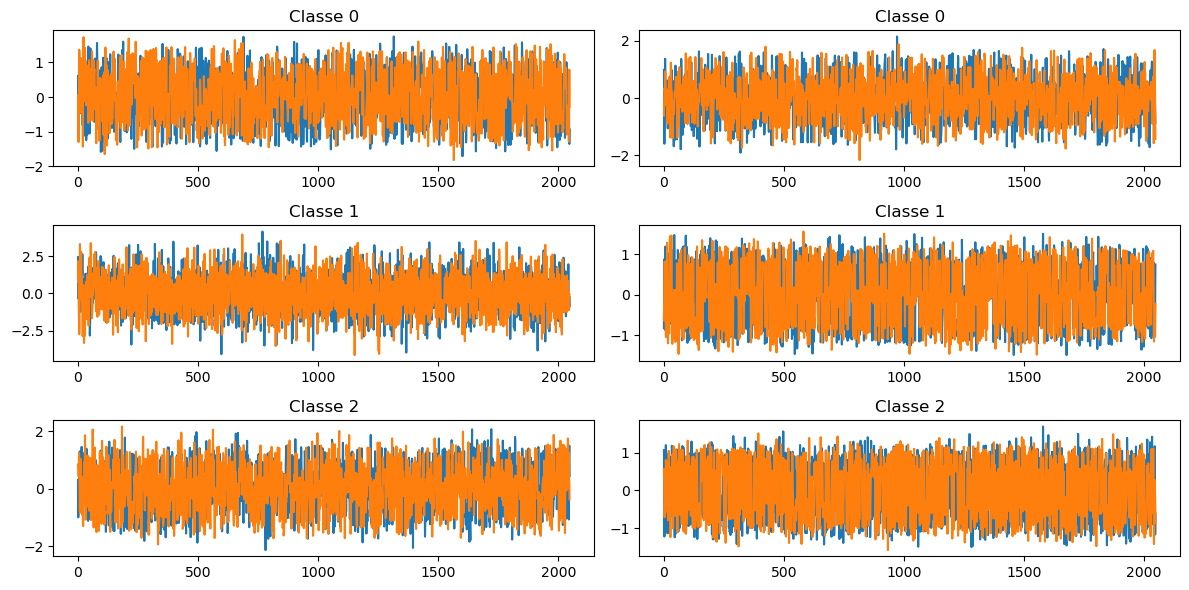

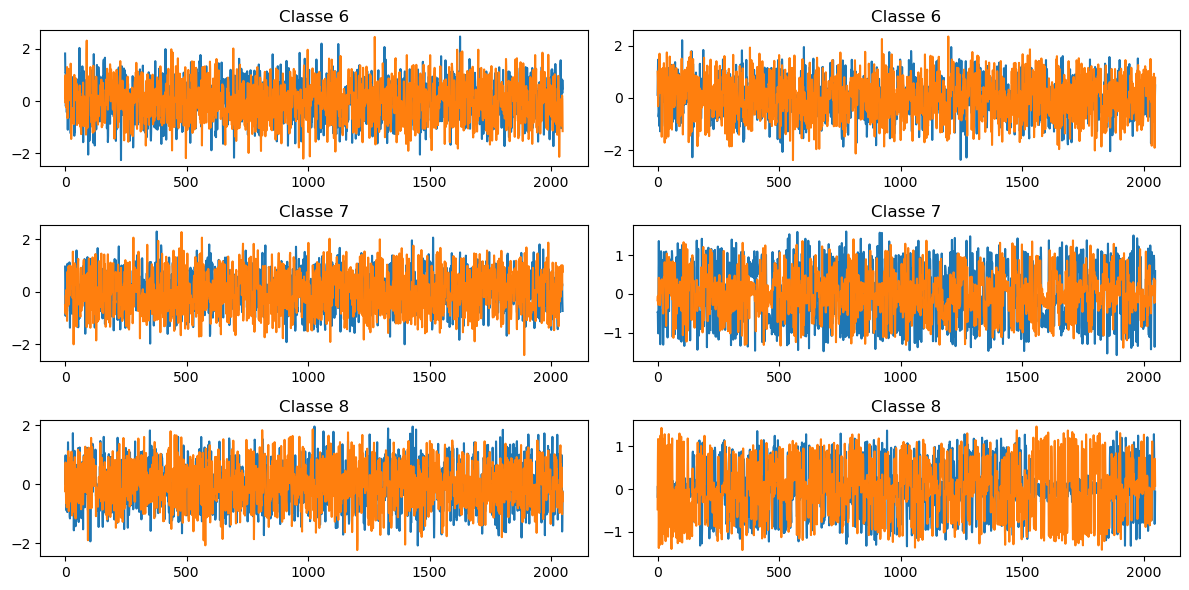

In [9]:
def plot_examples(path, classes_to_show, n=3):
    with h5py.File(path, "r") as f:
        X = f["signaux"][:]
        y = f["labels"][:]

    plt.figure(figsize=(12, 6))
    idx = 1

    for cls in classes_to_show:
        samples = X[y == cls][:n]
        for s in samples:
            plt.subplot(len(classes_to_show), n, idx)
            plt.plot(s)
            plt.title(f"Classe {cls}")
            plt.tight_layout()
            idx += 1

plot_examples(paths["train"], classes_to_show=[0,1,2], n=2)
plot_examples(paths["enroll"], classes_to_show=[6,7,8], n=2)


### Vizualisation

#### Real part

[4 3 3 ... 3 2 0]


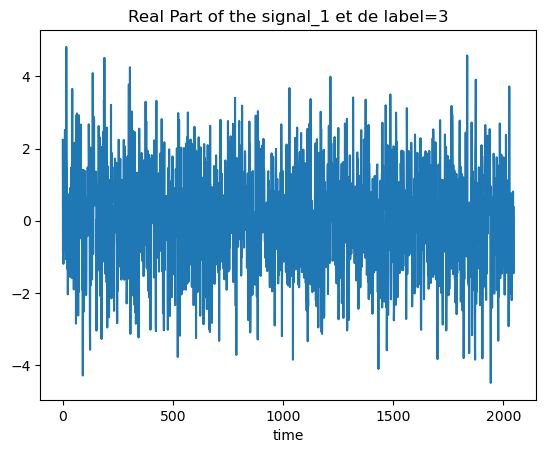

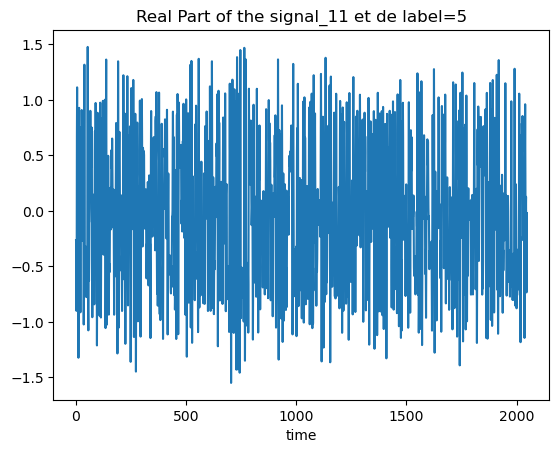

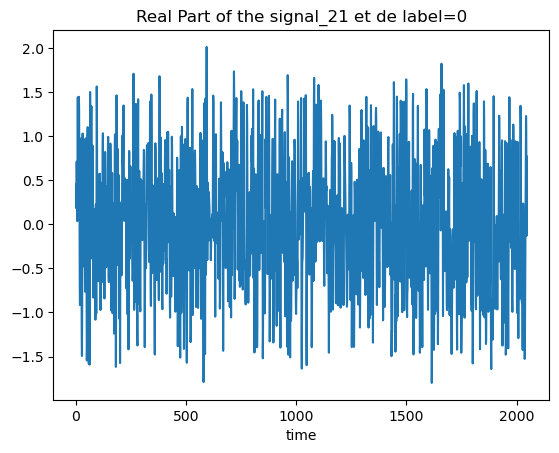

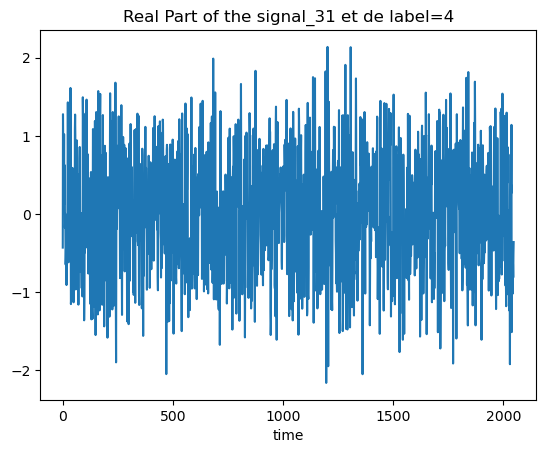

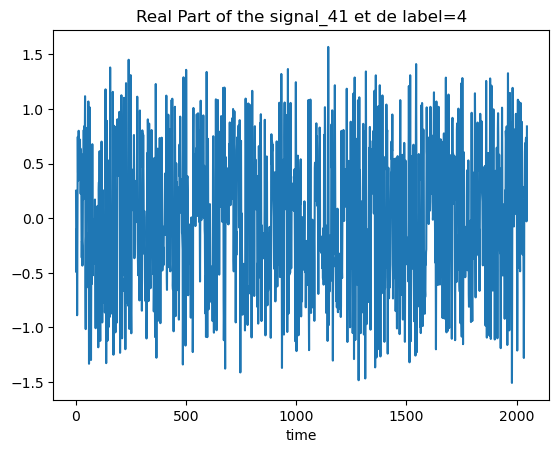

In [3]:
signals,_, labels_id = load_file(TRAIN_PATH)
print(labels_id)
#real signals
for i in range(1,50,10):
    plt.plot([t for t in range(len(signals[i,:,0]))],signals[i,:,0])
    plt.title(f"Real Part of the signal_{i} et de label={ labels_id[i]}")
    plt.xlabel("time")
    plt.show()

#### Imaginary part

## Dataloaders

In [13]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.functional as F

In [5]:
class BasicDataset(Dataset):
    def __init__(self, signals, labels, transform=None):
        self.signals = signals
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        x = self.signals[idx]
        y = self.labels[idx]
        
        x = torch.tensor(x, dtype=torch.float32)
        x = x.permute(1,0)  

        return x, torch.tensor(y, dtype=torch.long)



In [9]:
X, _, y = load_file(TRAIN_PATH)

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.1,
    stratify=y,
    random_state=42
)



In [10]:
print("Shape X :", X_train.shape)
print("Shape y :", y_train.shape)
print("Classes :", np.unique(y_train))


Shape X : (27000, 2048, 2)
Shape y : (27000,)
Classes : [0 1 2 3 4 5]


In [12]:
train_dataset = BasicDataset(X_train, y_train)
val_dataset   = BasicDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)

## Pipeline

### Modèle

In [14]:
class SimpleEncoder(nn.Module):
    def __init__(self, emb_dim=64):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  
        )
        
        self.fc = nn.Linear(128, emb_dim) 
        
    def forward(self, x):
        x = self.cnn(x)         
        x = x.squeeze(-1)       
        x = self.fc(x)          
        return x


In [15]:
class Classifier(nn.Module):
    def __init__(self, encoder, emb_dim=64):
        super().__init__()
        self.encoder = encoder
        self.fc = nn.Linear(emb_dim, 6) 
    
    def forward(self, x):
        z = self.encoder(x)
        logits = self.fc(z)
        return logits


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

encoder = SimpleEncoder(emb_dim=64).to(device)
model = Classifier(encoder, emb_dim=64).to(device)

save_path = f"models/simple_model.pth"


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


from tqdm import tqdm

num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    total = 0

    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        
        logits = model(xb)
        loss = criterion(logits, yb)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        train_correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_acc = train_correct / total
    train_loss = train_loss / total

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            xb, yb = xb.to(device), yb.to(device)

            logits = model(xb)
            loss = criterion(logits, yb)

            val_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds == yb).sum().item()
            total_val += yb.size(0)

    val_acc = val_correct / total_val
    val_loss = val_loss / total_val

    print(f"\nEpoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.3f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.3f}\n")
    

torch.save(model.state_dict(), save_path")
print(f"Modèle sauvegardé dans {save_path}")




Epoch 1/3 [Val]: 100%|██████████| 47/47 [00:05<00:00,  8.09it/s]



Epoch 1/3 | Train Loss: 1.2607 | Train Acc: 0.305 | Val Loss: 1.1206 | Val Acc: 0.340



Epoch 2/3 [Val]: 100%|██████████| 47/47 [00:06<00:00,  7.22it/s]



Epoch 2/3 | Train Loss: 1.1191 | Train Acc: 0.337 | Val Loss: 1.1159 | Val Acc: 0.330



Epoch 3/3 [Val]: 100%|██████████| 47/47 [00:07<00:00,  6.20it/s]



Epoch 3/3 | Train Loss: 1.0992 | Train Acc: 0.376 | Val Loss: 0.9998 | Val Acc: 0.425

Modèle sauvegardé dans simple_model.pth


### Few shot learning

In [ ]:
encoder = SimpleEncoder(emb_dim=64)
model = Classifier(encoder, emb_dim=64)

model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)
model.eval()

print("Modèle SimpleEncoder+Classifier chargé ✔️")


Modèle SimpleEncoder+Classifier chargé ✔️


In [25]:
encoder = model.encoder
encoder.eval()
encoder.to(device)

SimpleEncoder(
  (cnn): Sequential(
    (0): Conv1d(2, 32, kernel_size=(5,), stride=(2,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(5,), stride=(2,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(64, 128, kernel_size=(5,), stride=(2,), padding=(2,))
    (5): ReLU()
    (6): AdaptiveAvgPool1d(output_size=1)
  )
  (fc): Linear(in_features=128, out_features=64, bias=True)
)

In [33]:
X_few_shot, _, y_few_shot = load_file(ENROLL_PATH)
X_test, _, y_test = load_file(TEST_PATH)

X_few_shot = torch.tensor(X_few_shot, dtype=torch.float32).permute(0,2,1)  
y_few_shot = torch.tensor(y_few_shot, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32).permute(0,2,1)
y_test = torch.tensor(y_test, dtype=torch.long)


def sample_k_per_class(X, y, k):
    Xk, yk = [], []
    classes = torch.unique(y)

    for c in classes:
        idx = torch.where(y == c)[0]
        chosen = idx[torch.randperm(len(idx))[:k]]
        Xk.append(X[chosen])
        yk.append(y[chosen])

    return torch.cat(Xk), torch.cat(yk)

X_few_shot, y_few_shot = sample_k_per_class(X_few_shot, y_few_shot, k=1)




In [53]:
def compute_prototypes(encoder, X, y):
    encoder.eval()
    classes = torch.unique(y)
    protos = []
    labels = []

    with torch.no_grad():
        for c in classes:
            Xc = X[y == c].to(device)
            z = encoder(Xc)
            proto = z.mean(dim=0)  
            protos.append(proto)
            labels.append(c)

    return torch.stack(protos), torch.tensor(labels)

prototypes, proto_labels = compute_prototypes(encoder, X_few_shot, y_few_shot)




def classify(encoder, X_test, prototypes, proto_labels):
    encoder.eval()
    preds = []

    with torch.no_grad():
        z = encoder(X_test.to(device))  
        dists = torch.cdist(z, prototypes)  
        pred_idx = dists.argmin(dim=1)
        preds = proto_labels[pred_idx]

    return preds




preds = classify(encoder, X_test, prototypes, proto_labels)
acc = (preds.cpu() == y_test).float().mean()
print("Few-shot accuracy :", acc.item())





Few-shot accuracy : 0.16200000047683716


## Résultats

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

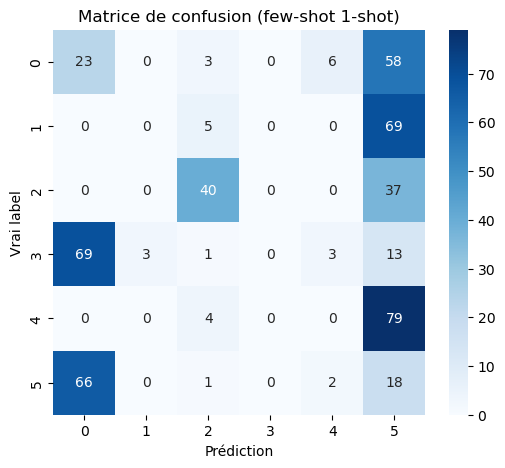

In [54]:
preds = classify(encoder, X_test, prototypes, proto_labels)
preds = preds.cpu()
true = y_test.cpu()

cm = confusion_matrix(true, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Vrai label")
plt.xlabel("Prédiction")
plt.title("Matrice de confusion (few-shot 1-shot)")
plt.show()


### Tsne

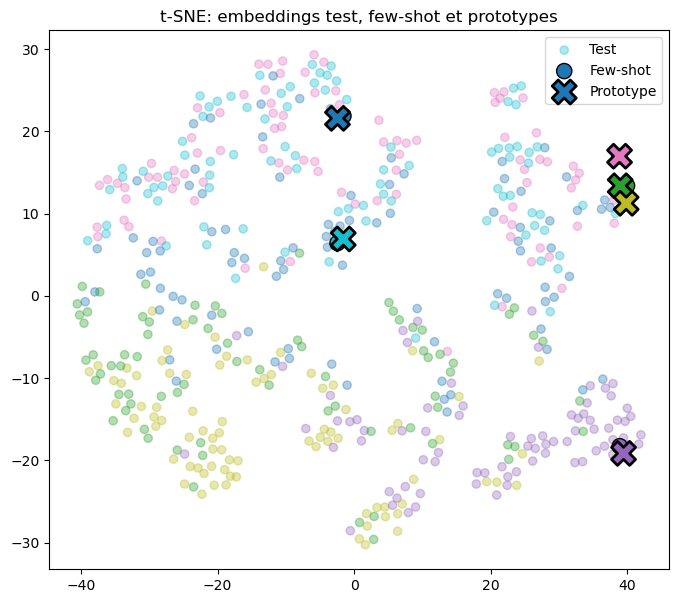

In [ ]:
encoder.eval()

with torch.no_grad():
    Z_test = encoder(X_test.to(device)).cpu()
    Z_few  = encoder(X_few_shot.to(device)).cpu()
    Z_proto = prototypes.cpu()

Z_all = torch.cat([Z_test, Z_few, Z_proto], dim=0)

labels_all = torch.cat([
    y_test,                      
    y_few_shot,                  
    proto_labels                 

])

point_type = torch.cat([
    torch.zeros(len(Z_test)),        
    torch.ones(len(Z_few)),          
    torch.ones(len(Z_proto)) * 2     
])



tsne = TSNE(n_components=2, perplexity=20, learning_rate=200, n_iter=2000)
Z_2D = tsne.fit_transform(Z_all.numpy())


plt.figure(figsize=(8, 7))

mask_test = (point_type == 0)
plt.scatter(
    Z_2D[mask_test,0], Z_2D[mask_test,1],
    c=labels_all[mask_test], cmap="tab10", alpha=0.35, label="Test"
)

mask_few = (point_type == 1)
plt.scatter(
    Z_2D[mask_few,0], Z_2D[mask_few,1],
    c=labels_all[mask_few], cmap="tab10", edgecolors="black",
    s=120, marker="o", label="Few-shot"
)

mask_proto = (point_type == 2)
plt.scatter(
    Z_2D[mask_proto,0], Z_2D[mask_proto,1],
    c=labels_all[mask_proto], cmap="tab10",
    s=300, marker="X", edgecolors="black", linewidths=2,
    label="Prototype"
)

plt.title("t-SNE: embeddings test, few-shot et prototypes")
plt.legend()
plt.show()



